<a href="https://colab.research.google.com/github/Alveuz/Intro2MLwithPython/blob/master/notebooks/02-RegresionLinealwoAns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Práctica 3

Gerardo Mauricio Toledo Acosta

--- 
## 0. Planteamiento

Con el fin de entender **un poquitín** mejor el estado de la pandemia por el COVID19 en México, realizaremos un pronóstico de los **nuevos casos por día** en la semana del **26 de Abril al 1 de Mayo** del 2020.

Asumiremos que ES POSIBLE predecir el comportamiento de los **nuevos casos por día** a partir del comportamiento de otros paises utilizando una regresión lineal. En este sentido, asumimos que:
1. el número de **nuevos casos por día** es un reflejo de las características de los los diferentes paises como las medidas tomadas respecto al distanciamiento social, distribución socioeconómica, conectividad con otros paises, tiempo del primer caso, condiciones ambientales, etc.
2. Es posible predecir los **nuevos casos por día** utilizando una RLM (al menos a corto plazo).

Para esto deberán utilizar los datos del [COVID19 (HAGA CLICK AQUÍ)](https://datahub.io/core/covid-19#data). Recuerde que esta BD requiere ser manipulada en dos pasos: 1) Pivotear la tabla para tener los casos acumulados de los países en cada columna y los renglones correspondan al registro, 2) Diferenciar los casos acumulados respecto al dia anterior, para tener los **nuevos casos por día** (pueden apoyarse [01Intro2PP](https://github.com/Alveuz/Intro2MLwithPython/blob/master/notebooks/01Intro2PPwAns.ipynb) para el primero y en [01EDA](https://github.com/Alveuz/Intro2MLwithPython/blob/master/notebooks/01EDAwAns.ipynb) para el segundo). 

El modelo que deben utilizar debe incluir las siguientes caracteristicas:

1. $X$ tiene que estar estandarizado
2. Debemos usar funciones base para generar un polinómio de orden 5
3. Seleccione las 10 variables con mayor correlación.
4. Se debe predecir sobre ``X_test`` estandarizado.
5. Para predecir, solo puede usar la información disponible hasta el 25 de Abril.
6. Calcule el error de la RLM usando $R^2$ y RMSE. Imprima ambos.

**Fecha Entrega: 8 de Mayo**

## 1. Importar paquetes

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import data_table
import seaborn as sns; sns.set()
from numpy.linalg import inv
import numpy as np
import pandas as pd
plt.style.use('seaborn-dark')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Cargar datos y pre-procesamiento

In [ ]:
big_df = pd.read_csv('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Módulo 3/Práctica 3/time-series-19-covid-combined_csv.csv')
big_df

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
1,2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2,2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
3,2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
4,2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
27659,2020-04-30,Zimbabwe,NaN,-20.0,30.0,40.0,5.0,4.0
27660,2020-05-01,Zimbabwe,NaN,-20.0,30.0,40.0,5.0,4.0
27661,2020-05-02,Zimbabwe,NaN,-20.0,30.0,34.0,5.0,4.0
27662,2020-05-03,Zimbabwe,NaN,-20.0,30.0,34.0,5.0,4.0


Pivoteamos la tabla

In [ ]:
cases_df = pd.pivot_table(big_df, values='Confirmed', index=['Date'],columns=['Country/Region'], aggfunc=np.sum)
cases_df.to_csv("/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Módulo 3/Práctica 3/Cases per day.csv")
cases_df

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo (Brazzaville),...,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,548.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,643.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,920.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1406.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2075.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30,2171.0,773.0,4006.0,745.0,27.0,24.0,4428.0,2066.0,6766.0,15452.0,1804.0,81.0,3040.0,7667.0,81.0,14027.0,48519.0,18.0,64.0,7.0,1110.0,1757.0,23.0,87187.0,138.0,1506.0,645.0,151.0,11.0,121.0,122.0,1832.0,54457.0,50.0,73.0,16023.0,83956.0,6507.0,1.0,220.0,...,933.0,9009.0,11.0,124.0,16169.0,1396.0,1429.0,601.0,5647.0,35.0,213435.0,663.0,442.0,10.0,21092.0,29586.0,43.0,429.0,15.0,480.0,2954.0,24.0,116.0,116.0,994.0,120204.0,1069424.0,83.0,10406.0,12481.0,172481.0,643.0,2039.0,333.0,270.0,344.0,6.0,6.0,106.0,40.0
2020-05-01,2335.0,782.0,4154.0,745.0,30.0,25.0,4532.0,2148.0,6778.0,15531.0,1854.0,81.0,3170.0,8238.0,81.0,14917.0,49032.0,18.0,90.0,7.0,1229.0,1781.0,23.0,92202.0,138.0,1555.0,649.0,151.0,11.0,122.0,122.0,1832.0,56343.0,72.0,73.0,17008.0,83959.0,7006.0,1.0,229.0,...,1024.0,9009.0,11.0,136.0,17101.0,1403.0,1434.0,601.0,5951.0,45.0,213435.0,690.0,533.0,10.0,21520.0,29705.0,44.0,429.0,15.0,480.0,2960.0,24.0,123.0,116.0,998.0,122392.0,1103461.0,85.0,10861.0,13038.0,178685.0,648.0,2086.0,335.0,270.0,353.0,6.0,7.0,109.0,40.0
2020-05-02,2469.0,789.0,4295.0,747.0,35.0,25.0,468

Cambiamos el formato de la columna `Date`, en caso de ser `string`.

In [ ]:
if (type(cases_df['Date'].iloc[0])==str):
    cases_df['Date'] = pd.to_datetime(cases_df['Date'],format='%Y-%m-%d')
    print("Se cambió el formato de la columna 'Date' a fecha.")
else:
    print("No hace falta cambiar el formato")

No hace falta cambiar el formato


Calcular el número de casos nuevos por día

In [ ]:
# Solo queremos aplicar la función diff() a las columnas de paises, no a la de 'Date'
colz = cases_df.columns.to_list()
colz = colz[1:]
new_cases_df = cases_df[colz].diff()
# Actualizamos el dateframe de casos, ahora tendrá casos nuevos solamente
cases_df.update(new_cases_df)
cases_df
# Guardamos el dataframe en csv para ya no tener que hacer el preprocesamiento otra vez
cases_df.to_csv("/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Módulo 3/Práctica 3/New cases per day.csv")

Country/Region,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,...,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,548.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,277.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,486.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,669.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2020-04-30,232.0,7.0,158.0,2.0,0.0,0.0,143.0,134.0,14.0,50.0,38.0,1.0,119.0,564.0,1.0,846.0,660.0,0.0,0.0,0.0,0.0,80.0,0.0,7502.0,0.0,59.0,4.0,1.0,0.0,7.0,0.0,0.0,1592.0,0.0,21.0,1138.0,12.0,300.0,1.0,...,51.0,285.0,0.0,20.0,528.0,5.0,11.0,19.0,297.0,1.0,518.0,14.0,67.0,0.0,790.0,179.0,0.0,0.0,15.0,0.0,7.0,0.0,7.0,0.0,14.0,2615.0,29515.0,2.0,540.0,552.0,6040.0,13.0,37.0,2.0,0.0,0.0,0.0,0.0,9.0,8.0
100,2020-05-01,164.0,9.0,148.0,0.0,3.0,1.0,104.0,82.0,12.0,79.0,50.0,0.0,130.0,571.0,0.0,890.0,513.0,0.0,26.0,0.0,119.0,24.0,0.0,5015.0,0.0,49.0,4.0,0.0,0.0,1.0,0.0,0.0,1886.0,22.0,0.0,985.0,3.0,499.0,0.0,...,91.0,0.0,0.0,12.0,932.0,7.0,5.0,0.0,304.0,10.0,0.0,27.0,91.0,0.0,428.0,119.0,1.0,0.0,0.0,0.0,6.0,0.0,7.0,0.0,4.0,2188.0,34037.0,2.0,455.0,557.0,6204.0,5.0,47.0,2.0,0.0,9.0,0.0,1.0,3.0,0.0
101,2020-05-02,134.0,7.0,141.0,2.0,5.0,0.0,149.0,125.0,21.0,27.0,40.0,2.0,114.0,552.0,0.0,911.0,485.0,0.0,0.0,0.0,0.0,58.0,0.0,4898.0,0.0,39.0,3.0,0.0,4.0,30.0,0.0,245.0,1583.0,0.0,44.0,1427.0,0.0,279.0,2.0,...,91.0,353.0,0.0,19.0,447.0,4.0,5.0,70.0,385.0,0.0,3147.0,15.0,59.0,0.0,562.0,112.0,0.0,3.0,61.0,0.0,6.0,0.0,0.0,0.0,11.0,1983.0,29078.0,3.0,550.0,561.0,4815.0,4.0,32.0,10.0,0.0,0.0,0.0,3.0,10.0,-6.0
102,2

## 3. Regresión Lineal

In [ ]:
cases_df = pd.read_csv('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Módulo 3/Práctica 3/New cases per day.csv',index_col=0)
cases_df

,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,...,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
0,2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,548.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,277.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,486.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,669.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2020-04-30,232.0,7.0,158.0,2.0,0.0,0.0,143.0,134.0,14.0,50.0,38.0,1.0,119.0,564.0,1.0,846.0,660.0,0.0,0.0,0.0,0.0,80.0,0.0,7502.0,0.0,59.0,4.0,1.0,0.0,7.0,0.0,0.0,1592.0,0.0,21.0,1138.0,12.0,300.0,1.0,...,51.0,285.0,0.0,20.0,528.0,5.0,11.0,19.0,297.0,1.0,518.0,14.0,67.0,0.0,790.0,179.0,0.0,0.0,15.0,0.0,7.0,0.0,7.0,0.0,14.0,2615.0,29515.0,2.0,540.0,552.0,6040.0,13.0,37.0,2.0,0.0,0.0,0.0,0.0,9.0,8.0
100,2020-05-01,164.0,9.0,148.0,0.0,3.0,1.0,104.0,82.0,12.0,79.0,50.0,0.0,130.0,571.0,0.0,890.0,513.0,0.0,26.0,0.0,119.0,24.0,0.0,5015.0,0.0,49.0,4.0,0.0,0.0,1.0,0.0,0.0,1886.0,22.0,0.0,985.0,3.0,499.0,0.0,...,91.0,0.0,0.0,12.0,932.0,7.0,5.0,0.0,304.0,10.0,0.0,27.0,91.0,0.0,428.0,119.0,1.0,0.0,0.0,0.0,6.0,0.0,7.0,0.0,4.0,2188.0,34037.0,2.0,455.0,557.0,6204.0,5.0,47.0,2.0,0.0,9.0,0.0,1.0,3.0,0.0
101,2020-05-02,134.0,7.0,141.0,2.0,5.0,0.0,149.0,125.0,21.0,27.0,40.0,2.0,114.0,552.0,0.0,911.0,485.0,0.0,0.0,0.0,0.0,58.0,0.0,4898.0,0.0,39.0,3.0,0.0,4.0,30.0,0.0,245.0,1583.0,0.0,44.0,1427.0,0.0,279.0,2.0,...,91.0,353.0,0.0,19.0,447.0,4.0,5.0,70.0,385.0,0.0,3147.0,15.0,59.0,0.0,562.0,112.0,0.0,3.0,61.0,0.0,6.0,0.0,0.0,0.0,11.0,1983.0,29078.0,3.0,550.0,561.0,4815.0,4.0,32.0,10.0,0.0,0.0,0.0,3.0,10.0,-6.0
102,2020-05-03,235.

El planteamiento será el siguiente:

El conjunto `X_train` será los casos nuevos diarios por pais (todos los paises excepto México), hasta el 25 de abril (incluido).

El conjunto `y_train` será los casos nuevos diarios en México en el rango de fechas anterior.

El conjunto `X_test` serán los casos nuevos diarios por pais (todos los paises excepto México), en el lapso 26-abril / 1-mayo.

El conjunto `y_test` serán los casos nuevos diarios en México en el rango de fechas del parrafo anterior.


Para `X_train` y `X_test` solamente tomaremos los 10 paises con las correlaciones más altas. Estos datos estarán normalizados.

Usaremos 3 procedimientos distintos. En cada subsección explico lo que hice. El error más bajo que obtuve fue con el último método.

Dividimos los datos de acuerdo a las consideraciones anteriores.

In [ ]:
# Obtener el índice de la fecha 25-abril
idx_1 = cases_df[cases_df['Date']=='2020-04-25'].index.to_list()[0]
# Obtener el índice de la fecha 1-mayo
idx_2 = cases_df[cases_df['Date']=='2020-05-01'].index.to_list()[0]
lista_paises = cases_df.columns.to_list()[1:]
lista_paises_wo_Mexico = lista_paises.copy()
lista_paises_wo_Mexico.remove('Mexico')

In [ ]:
# Obtener las matrices totales, de entrenamiento y de prueba
X = cases_df.loc[:idx_2,lista_paises_wo_Mexico].to_numpy()
y = cases_df.loc[:idx_2,'Mexico'].to_numpy()
X_train = cases_df.loc[:idx_1,lista_paises_wo_Mexico].to_numpy()
y_train = cases_df.loc[:idx_1,'Mexico'].to_numpy()
X_test = cases_df.loc[idx_1+1:idx_2,lista_paises_wo_Mexico].to_numpy()
y_test = cases_df.loc[idx_1+1:idx_2,'Mexico'].to_numpy()

### Procedimiento 1: Ver los 10 paises con mayor correlación con México

Vemos los 10 paises con mayor correlación con México, con esos formamos la matriz $X_\text{train}$ y luego aplicamos el pipeline:

$\text{StandardScaler}\rightarrow\text{PolynomialFeatures}\rightarrow\text{LinearRegression}$ 

In [ ]:
# Generamos la matriz de correlaciones
correlation_df = cases_df[lista_paises].corr()
# Nos fijamos solamente en las correlaciones con México y escogemos los que tengan las 10 mayores (en valor absoluto)
Top_10 = correlation_df['Mexico'].sort_values(ascending=False).index.to_list()[1:11]
print(Top_10)

['Russia', 'Saudi Arabia', 'Brazil', 'Bangladesh', 'Kuwait', 'Egypt', 'India', 'Qatar', 'Pakistan', 'Nigeria']


In [ ]:
# Obtener las matrices totales, de entrenamiento y de prueba
X = cases_df.loc[:idx_2,Top_10].to_numpy()
y = cases_df.loc[:idx_2,'Mexico'].to_numpy()
X_train = cases_df.loc[:idx_1,Top_10].to_numpy()
y_train = cases_df.loc[:idx_1,'Mexico'].to_numpy()
X_test = cases_df.loc[idx_1+1:idx_2,Top_10].to_numpy()
y_test = cases_df.loc[idx_1+1:idx_2,'Mexico'].to_numpy()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Crear pipeline
das_Model = make_pipeline(StandardScaler(),PolynomialFeatures(5),LinearRegression())

das_Model.fit(X_train,y_train)
y_predicted = das_Model.predict(X_test)

print("R-squared:",r2_score(y_test,y_predicted))
print("RSME:",mean_squared_error(y_test,y_predicted))

R-squared: -256712512.46160698
RSME: 17662484100151.668


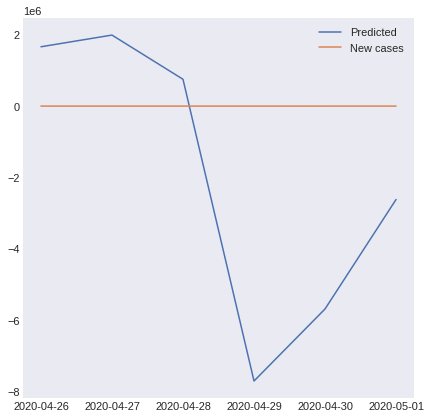

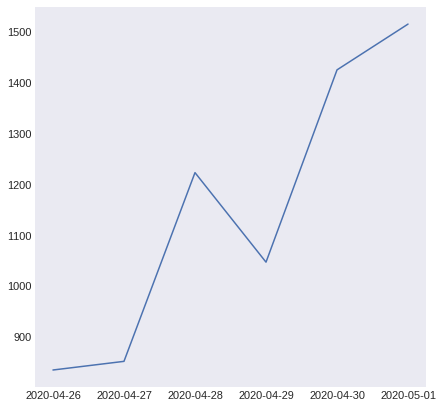

In [ ]:
plt.figure(figsize=(7,7))

x = np.array(cases_df.loc[idx_1+1:idx_2,'Date'])
plt.plot(x,y_predicted,label="Predicted")
plt.plot(x,y_test,label="New cases")
plt.legend(loc='best')
plt.show()

# Los puros casos nuevos
plt.figure(figsize=(7,7))
plt.plot(x,y_test)
plt.show()

Como podemos ver, con este enfoque la predicción es totalmente inútil.


### Procedimiento 2

Ver los 10 paises con mayor correlación con México, después hacer PolynomialFeatures y escoger las 10 variables con mayor correlación. Con esto formamos la matriz $X_\text{train}$ y aplicamos el pipeline:

$\text{StandardScaler}\rightarrow\text{LinearRegression}$ 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()
poly = PolynomialFeatures(5)

#Standardize X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

#Construct their respective DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, 
                              index=cases_df.loc[:idx_1,Top_10].index, 
                              columns=cases_df.loc[:idx_1,Top_10].columns)

X_test_scaled_df = pd.DataFrame(X_test_scaled, 
                              index=cases_df.loc[idx_1+1:idx_2,Top_10].index, 
                              columns=cases_df.loc[idx_1+1:idx_2,Top_10].columns)

# Create PolynomialFeatures
p_model = poly.fit(X_train_scaled_df)
poly_names  = p_model.get_feature_names(X_train_scaled_df.columns)

# Transform X_train_scl into X_train_poly where polynomial features are stored
X_train_poly = poly.fit_transform(X_train_scaled_df)
X_train_poly_df = pd.DataFrame(X_train_poly, index=cases_df.loc[:idx_1,Top_10].index, columns= poly_names)

# Transform also X_test_scl
X_test_poly = poly.fit_transform(X_test_scaled_df)
X_test_poly_df = pd.DataFrame(X_test_poly, index=cases_df.loc[idx_1+1:idx_2,Top_10].index, columns= poly_names)

#Create the full Train_df which is the matrix composed by Xy
all_names = np.concatenate((X_train_poly_df.columns, 'Mexico'), axis=None)
Train_ndarray = np.hstack([X_train_poly_df, y_train[:, np.newaxis]])
Train_df = pd.DataFrame(Train_ndarray,index=cases_df.loc[:idx_1,Top_10].index,columns = all_names)

# Compute the correlation matrix
corr_mtx = Train_df.corr()

# Escogemos las 10 combinaciones de variables con mayor correlación con México
Top_10_variables = corr_mtx.iloc[1:3003,-1].abs().sort_values(ascending=False).head(10).index.to_list()

# Armamos la nueva matriz X_train
X_train = X_train_poly_df.loc[:,Top_10_variables].to_numpy()
y_train = cases_df.loc[:idx_1,'Mexico'].to_numpy() # Esta ya estaba definida
X_test = X_test_poly_df.loc[:,Top_10_variables].to_numpy()
y_test = cases_df.loc[idx_1+1:idx_2,'Mexico'].to_numpy() # Esta ya estaba definida

In [ ]:
# Crear pipeline
das_Model = make_pipeline(StandardScaler(),LinearRegression())
# Ajuste y predicción
das_Model.fit(X_train,y_train)
y_predicted = das_Model.predict(X_test)
# Medición del error
print("R-squared:",r2_score(y_test,y_predicted))
print("RSME:",mean_squared_error(y_test,y_predicted))

R-squared: -15.560405973983432
RSME: 1139398.7120588261


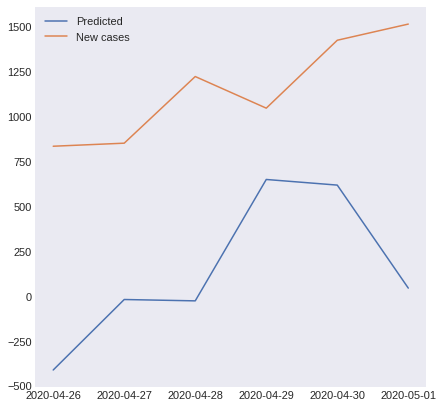

In [ ]:
plt.figure(figsize=(7,7))
x = np.array(cases_df.loc[idx_1+1:idx_2,'Date'])
plt.plot(x,y_predicted,label="Predicted")
plt.plot(x,y_test,label="New cases")
plt.legend(loc='best')
plt.show()

Como podemos ver, el error ya no es tan grande. Lo malo, son los casos negativos.

### Procedimiento 3: Casi igual que el anterior.

Es igual al procedimiento 2, pero al tomar los 10 elementos con mayor correlacion, no tomamos el valor absoluto.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()
poly = PolynomialFeatures(5)

#Standardize X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

#Construct their respective DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, 
                              index=cases_df.loc[:idx_1,Top_10].index, 
                              columns=cases_df.loc[:idx_1,Top_10].columns)

X_test_scaled_df = pd.DataFrame(X_test_scaled, 
                              index=cases_df.loc[idx_1+1:idx_2,Top_10].index, 
                              columns=cases_df.loc[idx_1+1:idx_2,Top_10].columns)

# Create PolynomialFeatures
p_model = poly.fit(X_train_scaled_df)
poly_names  = p_model.get_feature_names(X_train_scaled_df.columns)

# Transform X_train_scl into X_train_poly where polynomial features are stored
X_train_poly = poly.fit_transform(X_train_scaled_df)
X_train_poly_df = pd.DataFrame(X_train_poly, index=cases_df.loc[:idx_1,Top_10].index, columns= poly_names)

# Transform also X_test_scl
X_test_poly = poly.fit_transform(X_test_scaled_df)
X_test_poly_df = pd.DataFrame(X_test_poly, index=cases_df.loc[idx_1+1:idx_2,Top_10].index, columns= poly_names)

#Create the full Train_df which is the matrix composed by Xy
all_names = np.concatenate((X_train_poly_df.columns, 'Mexico'), axis=None)
Train_ndarray = np.hstack([X_train_poly_df, y_train[:, np.newaxis]])
Train_df = pd.DataFrame(Train_ndarray,index=cases_df.loc[:idx_1,Top_10].index,columns = all_names)

# Compute the correlation matrix
corr_mtx = Train_df.corr()

# Escogemos las 10 combinaciones de variables con mayor correlación con México
Top_10_variables = corr_mtx.iloc[1:3003,-1].sort_values(ascending=False).head(10).index.to_list()

# Armamos la nueva matriz X_train
X_train = X_train_poly_df.loc[:,Top_10_variables].to_numpy()
y_train = cases_df.loc[:idx_1,'Mexico'].to_numpy() # Esta ya estaba definida
X_test = X_test_poly_df.loc[:,Top_10_variables].to_numpy()
y_test = cases_df.loc[idx_1+1:idx_2,'Mexico'].to_numpy() # Esta ya estaba definida

In [ ]:
# Crear pipeline
das_Model = make_pipeline(StandardScaler(),LinearRegression())
# Ajuste y predicción
das_Model.fit(X_train,y_train)
y_predicted = das_Model.predict(X_test)
# Medición del error
print("R-squared:",r2_score(y_test,y_predicted))
print("RSME:",mean_squared_error(y_test,y_predicted))

R-squared: -15.407953939331268
RSME: 1128909.6182403343


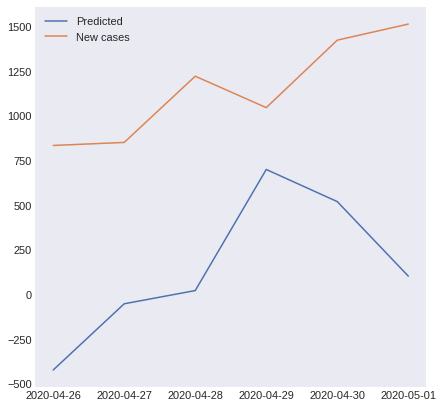

In [ ]:
plt.figure(figsize=(7,7))
x = np.array(cases_df.loc[idx_1+1:idx_2,'Date'])
plt.plot(x,y_predicted,label="Predicted")
plt.plot(x,y_test,label="New cases")
plt.legend(loc='best')
plt.show()

Como podemos ver, el error es basicamente el mismo.

### Procedimiento 4: Cambiar el grado del polinomio y las variables que seleccionamos.

La mejor combinación que obtuve:



*   $N = 12$ (Variables que seleccionamos)
*   $k = 5$ (Grado del polinomio)

R-squared: -14.038625933623733 

RSME: 1034696.3140169746

Aunque, nunca deje de tener casos negativos en la predicción.




R-squared: -3.1790690261449175
RSME: 287530.74492708786


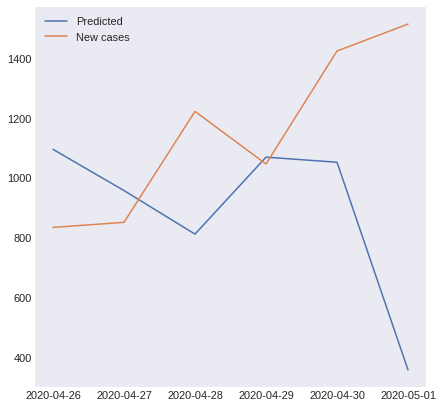

In [ ]:
N = 12 # Cuántos variables queremos tomar
k = 5 # grado del polinomio

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


# Generamos la matriz de correlaciones
correlation_df = cases_df[lista_paises].corr()
# Nos fijamos solamente en las correlaciones con México y escogemos los que tengan las 10 mayores (en valor absoluto)
Top_10 = correlation_df['Mexico'].sort_values(ascending=False).index.to_list()[1:N+1]
# Obtener las matrices totales, de entrenamiento y de prueba
X = cases_df.loc[:idx_2,Top_10].to_numpy()
y = cases_df.loc[:idx_2,'Mexico'].to_numpy()
X_train = cases_df.loc[:idx_1,Top_10].to_numpy()
y_train = cases_df.loc[:idx_1,'Mexico'].to_numpy()
X_test = cases_df.loc[idx_1+1:idx_2,Top_10].to_numpy()
y_test = cases_df.loc[idx_1+1:idx_2,'Mexico'].to_numpy()

scaler = StandardScaler()
poly = PolynomialFeatures(k)

#Standardize X_train and X_test
X_train_scaled =  X_train #scaler.fit_transform(X_train)
X_test_scaled =  X_test #scaler.fit_transform(X_test)

#Construct their respective DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, 
                              index=cases_df.loc[:idx_1,Top_10].index, 
                              columns=cases_df.loc[:idx_1,Top_10].columns)

X_test_scaled_df = pd.DataFrame(X_test_scaled, 
                              index=cases_df.loc[idx_1+1:idx_2,Top_10].index, 
                              columns=cases_df.loc[idx_1+1:idx_2,Top_10].columns)

# Create PolynomialFeatures
p_model = poly.fit(X_train_scaled_df)
poly_names  = p_model.get_feature_names(X_train_scaled_df.columns)

# Transform X_train_scl into X_train_poly where polynomial features are stored
X_train_poly = poly.fit_transform(X_train_scaled_df)
X_train_poly_df = pd.DataFrame(X_train_poly, index=cases_df.loc[:idx_1,Top_10].index, columns= poly_names)

# Transform also X_test_scl
X_test_poly = poly.fit_transform(X_test_scaled_df)
X_test_poly_df = pd.DataFrame(X_test_poly, index=cases_df.loc[idx_1+1:idx_2,Top_10].index, columns= poly_names)

#Create the full Train_df which is the matrix composed by Xy
all_names = np.concatenate((X_train_poly_df.columns, 'Mexico'), axis=None)
Train_ndarray = np.hstack([X_train_poly_df, y_train[:, np.newaxis]])
Train_df = pd.DataFrame(Train_ndarray,index=cases_df.loc[:idx_1,Top_10].index,columns = all_names)

# Compute the correlation matrix
corr_mtx = Train_df.corr()

# Escogemos las 10 combinaciones de variables con mayor correlación con México
Top_10_variables = corr_mtx.iloc[1:-2,-1].sort_values(ascending=False).head(N).index.to_list()

# Armamos la nueva matriz X_train
X_train = X_train_poly_df.loc[:,Top_10_variables].to_numpy()
y_train = cases_df.loc[:idx_1,'Mexico'].to_numpy() # Esta ya estaba definida
X_test = X_test_poly_df.loc[:,Top_10_variables].to_numpy()
y_test = cases_df.loc[idx_1+1:idx_2,'Mexico'].to_numpy() # Esta ya estaba definida

# Crear pipeline
das_Model = make_pipeline(StandardScaler(),LinearRegression())
# Ajuste y predicción
das_Model.fit(X_train,y_train)
y_predicted = das_Model.predict(X_test)
# Medición del error
print("R-squared:",r2_score(y_test,y_predicted))
print("RSME:",mean_squared_error(y_test,y_predicted))

# Graficar 
plt.figure(figsize=(7,7))
x = np.array(cases_df.loc[idx_1+1:idx_2,'Date'])
plt.plot(x,y_predicted,label="Predicted")
plt.plot(x,y_test,label="New cases")
plt.legend(loc='best')
plt.show()

Al intentar con varios grados de polinomios el error sigue siendo el mismo. Esto parece sugerir que esto es lo mejor que se puede predecir usando esta idea e hipótesis.